In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, models
import torch.nn.functional as F
from torchvision.models import resnet18
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy


from torchvision.models import resnet18, ResNet18_Weights

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Using pretrained weights:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
preprocess = ResNet18_Weights.DEFAULT.transforms()

cuda


In [2]:

processed_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess)
class_names = processed_trainset.classes
processed_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)
dataloaders = {'train' : [], 'val' : []}
dataloaders['train'] = torch.utils.data.DataLoader(processed_trainset, batch_size=100,
                                                    shuffle=True, num_workers=4, pin_memory=True)
dataloaders['val'] = torch.utils.data.DataLoader(processed_testset, batch_size=100,
                                                    shuffle=False, num_workers=4, pin_memory=True)
dataset_sizes = {'train' : len(processed_trainset), 'val' : len(processed_testset)}

Files already downloaded and verified
Files already downloaded and verified


In [2]:
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(512, 10)
model = model.cpu()

In [ ]:
for name, param in model.named_parameters():
    print(name, param.shape, param.requires_grad)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
dataset_sizes = {'train' : 50000 , 'val' : 10000}

In [ ]:
torch.save(model.state_dict(), 'resnet18_feats_cifar10.pyt')

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.cpu()
                labels = labels.cpu()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
model_conv, hist = train_model(model, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=50)

In [3]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
for name, param in model.named_parameters():
    print(name, param.shape, param.requires_grad)

In [ ]:
model.eval()
parameters = tuple(model.parameters())
sq_grads_expect = {i: np.zeros(p.shape) for i, p in enumerate(parameters)} # 

for test_batch, test_labels in dataloaders['val']:
    #model.zero_grad() moved this line
    outputs = model(test_batch)
    _, preds = torch.max(outputs, 1)
    print(torch.sum(preds == test_labels.data) / len(test_labels))
    
    probs = F.softmax(outputs, dim=1).to('cpu')
    log_probs = F.log_softmax(outputs, dim=1)
    N, C = log_probs.shape

    for n in range(N):
        for c in range(C):
            grad_list = torch.autograd.grad(log_probs[n][c], parameters, retain_graph=True)
            for i, grad in enumerate(grad_list):    # different layers
                gsq = torch.square(grad).to('cpu') * probs[n][c] / N
                sq_grads_expect[i] += gsq.detach().numpy() # sq_grads_expect[i] + gsq
                del gsq
            model.zero_grad()

In [ ]:
import pickle
pickle.dump(sq_grads_expect, open("save.p", "wb"))

In [ ]:
pickle.dump(model, open("model.p", "wb"))

In [ ]:
list_t = list(sq_grads_expect.values())

In [ ]:
combined_arrays = np.hstack([t.flatten() for t in sq_grads_expect.values()]) 

In [ ]:
list_lengths = [len(ten.flatten()) for ten in list_t]

In [ ]:
cum_lengths = np.cumsum(list_lengths)

In [ ]:
sorted_idxs = np.argsort(combined_arrays)

In [ ]:
num_top = int(0.02 * len(combined_arrays))
top_idxs = sorted_idxs[-num_top:]

In [ ]:
t_num = [[] for i in range(len(list_t))]
for idx in top_idxs:
    prev_length = 0
    for idx_layer_num, length in enumerate(cum_lengths):
        if idx < length and length > prev_length: 
            # print(len_idx)
            try:
                # s_num[len_idx].append(np.where(combined_s[idx] == list_s[len_idx])[0][0])
                idx_tuple = np.nonzero(combined_arrays[idx] == list_t[idx_layer_num])
                '''pass only numpy or python objects to numpy functions'''
                # s_num[len_idx].append([idx[0] for idx in idx_tuple])
                t_num[idx_layer_num].append(idx_tuple)
            except IndexError:
                print("caught error: ", idx, idx_layer_num, length, t_num)
            break
        prev_length = length
#print(t_num)

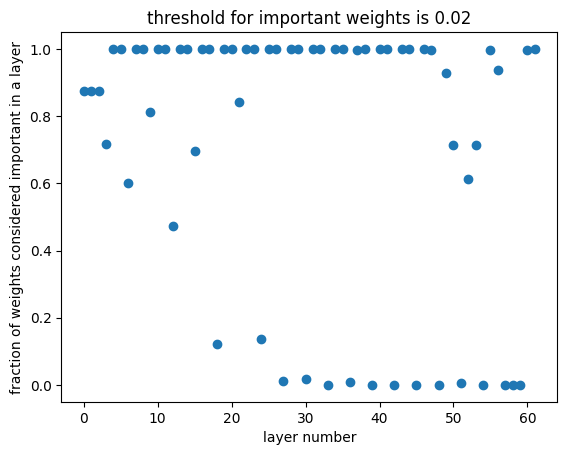

In [2]:
import matplotlib.pyplot as plt
# plt.plot([len(t) for t in t_num]) # gets biased by number of weights in a layer
plt.plot([len(t) / len(g.flatten()) for t, g in zip(t_num, list_t)], 'o')
plt.xlabel('layer number')
plt.ylabel('fraction of weights considered important in a layer')
plt.title('threshold for important weights is 0.02')
plt.show()

In [ ]:
important_layer_nums = np.nonzero([len(t) / len(g.flatten()) > 0.5 for t, g in zip(t_num, list_t)])

In [ ]:
important_layer_nums[0]

In [ ]:
parameters = tuple(model.named_parameters())
# parameters[-2][0]
[parameters[num][0] for num in important_layer_nums[0]] # 47 important layers
# [parameters[num][0] for num in range(62) if num not in important_layer_nums[0]]

In [ ]:
import dill
dill.dump_session('notebook_env.db')

In [4]:
import dill
dill.load_session('../notebook_env.db')